Objetivo: Avaliar diferentes modelos de Machine Learning para predição do Lead Time de entregas de delivery de alimentos.

In [44]:
# Bibliotecas para análise de dados
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliotecas para Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


#Caminho do Dataset
caminho_dataset = 'C:/Users/User/Desktop/GitHub/Data Science/Lead time Delivery/archive/Food_Delivery_Times.csv'
df = pd.read_csv(caminho_dataset)

In [23]:
# Primeira visão do dataset
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [24]:
# Removendo valores nulos e analisando estatísticas de variáveis quantitativas
df = df.dropna()
df.describe()

In [26]:
# Análise de outliers

cols = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Delivery_Time_min']

z_scores = df[cols].apply(zscore)
outliers_z = df[(z_scores.abs() > 3).any(axis=1)]

outliers_z.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 29 to 924
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                4 non-null      int64  
 1   Distance_km             4 non-null      float64
 2   Weather                 4 non-null      object 
 3   Traffic_Level           4 non-null      object 
 4   Time_of_Day             4 non-null      object 
 5   Vehicle_Type            4 non-null      object 
 6   Preparation_Time_min    4 non-null      int64  
 7   Courier_Experience_yrs  4 non-null      float64
 8   Delivery_Time_min       4 non-null      int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 320.0+ bytes


In [27]:
# Remoção de outliers do dataframe
df_clean = df[~df.index.isin(outliers_z.index)]

In [29]:
# Como o nível de tráfego é crescente (Low, Medium, High), é possível aplicar Label-Encoding para essa variável:
encoder = LabelEncoder()
df_clean['Traffic_Level'] = encoder.fit_transform(df_clean['Traffic_Level'])

C:\Users\User\AppData\Local\Temp\ipykernel_18620\21803638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Traffic_Level'] = encoder.fit_transform(df_clean['Traffic_Level'])


In [30]:
df_clean.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,1,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,2,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,1,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,2,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,1,Morning,Bike,16,5.0,68


In [31]:
# Aplicação de One-Hot Encoding para as demais variáveis qualitativas:
df_encoded = pd.get_dummies(df_clean, columns=['Weather', 'Time_of_Day', 'Vehicle_Type'])
df_encoded = df_encoded.drop(columns='Order_ID')
df_encoded.head()

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

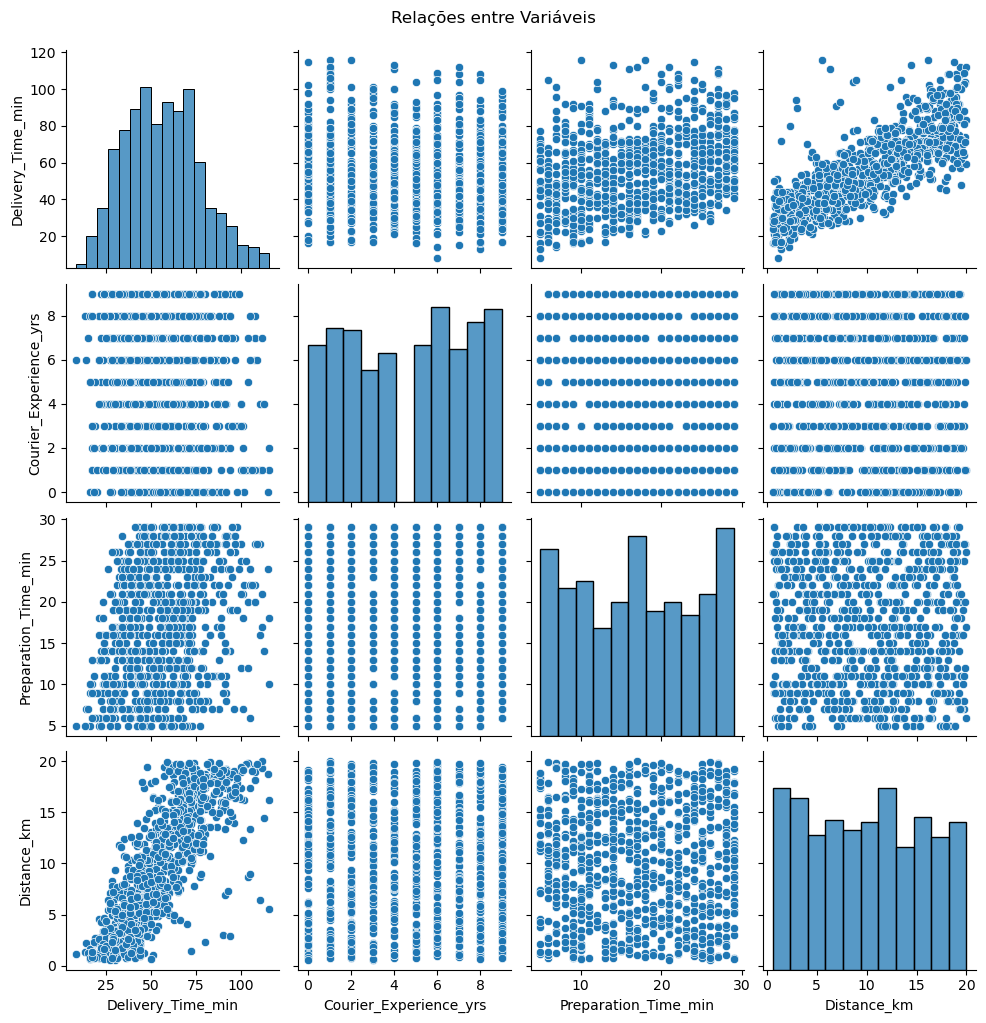

In [34]:
# Avaliando correlações
sns.pairplot(df_encoded[['Delivery_Time_min', 'Courier_Experience_yrs','Preparation_Time_min', 'Distance_km']])
plt.suptitle('Relações entre Variáveis', y=1.02)
plt.show()

In [35]:
# Split dos dados
X = df_encoded.drop('Delivery_Time_min', axis=1)
y = df_encoded['Delivery_Time_min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Função para calcular R2 Ajustado:

def r2_ajustado(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return 1 - (1 - r2) * (n - 1) / (n - n_features - 1)

In [45]:
# Testando Modelos

modelos = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR(),
    'XGBoost': XGBRegressor()
}

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    r2_adj = r2_ajustado(y_test, y_pred, X_test.shape[1])
    print(f'{nome}: R² ajustado = {r2_adj:.4f}')


Linear Regression: R² ajustado = 0.7587
Decision Tree: R² ajustado = 0.4350
Random Forest: R² ajustado = 0.7274
SVR: R² ajustado = 0.6773
XGBoost: R² ajustado = 0.6795


In [43]:
# Tunando Hiperparâmetros do Random Forest
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)

print('Melhores parâmetros:', grid.best_params_)
melhor_modelo = grid.best_estimator_


Melhores parâmetros: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [48]:
# Avaliando modelo Random Forest com parâmetros tunados:

modelo = RandomForestRegressor(max_depth=10, min_samples_split=2, n_estimators=200)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
r2_adj = r2_ajustado(y_test, y_pred, X_test.shape[1])
print(f'R² ajustado = {r2_adj:.4f}')

R² ajustado = 0.7309


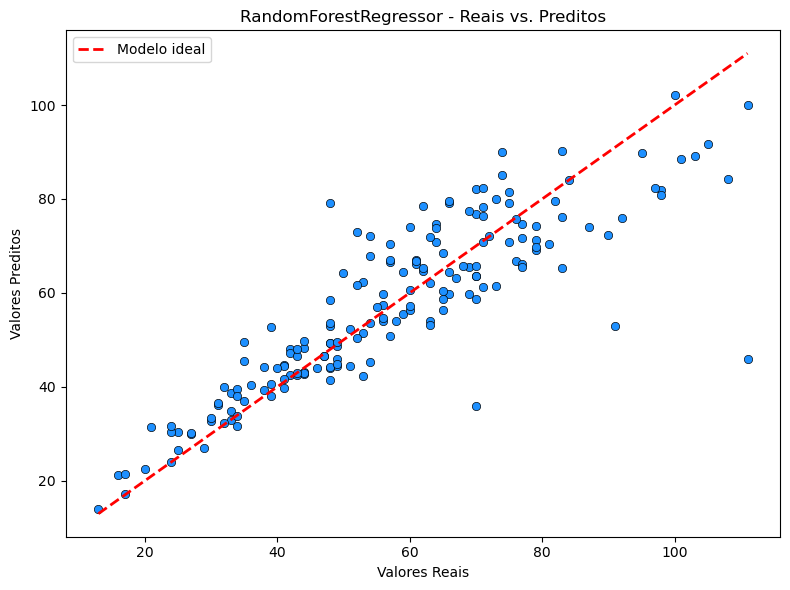

In [47]:
# Avaliação visual modelo Random Forest com parâmetros tunados:
modelo = RandomForestRegressor(max_depth=10, min_samples_split=2, n_estimators=200)

modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='dodgerblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Modelo ideal')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title(f'{modelo.__class__.__name__} - Reais vs. Preditos')
plt.legend()
plt.tight_layout()
plt.show()